In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline 

In [6]:
pd.set_option('display.max_rows', 100)

## Load Data

In [7]:
aisles = pd.read_csv('data/aisles.csv', dtype = {
    'aisle_id': np.uint16,
    'aisle': np.str},
    usecols=['aisle_id', 'aisle'])

In [8]:
departments = pd.read_csv('data/departments.csv', dtype = {
    'department_id': np.uint16,
    'department': np.str},
    usecols=['department_id', 'department'])

In [9]:
order_products_prior = pd.read_csv('data/order_products__prior.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint32,
    'add_to_cart_order': np.uint16,
    'reordered': np.uint16},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [10]:
order_product_train = pd.read_csv('data/order_products__train.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint32,
    'add_to_cart_order': np.uint16,
    'reordered': np.uint16},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [11]:
orders = pd.read_csv('data/orders.csv', dtype = {
    'order_id': np.uint32,
    'user_id' :np.uint32,
    'eval_set': 'category',
    'order_number': np.uint16,
    'order_dow': np.uint16,
    'order_hour_of_day': np.uint8,
    'days_since_prior_order': np.float32},
                     usecols=['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'])

In [12]:
products = pd.read_csv('data/products.csv', dtype = {'product_id': np.uint16,
        'product_name': np.str,
        'aisle_id': np.uint16,
        'department_id': np.uint16},
        usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])

In [ ]:
# priordf = pickle.load(open('data/pickle_files/priordf.p', 'rb'))
# user_info = pickle.load(open('data/pickle_files/user_info.p', 'rb'))
# product_info = pickle.load(open('data/pickle_files/product_info.p', 'rb'))
# user_product_info = pickle.load(open('data/pickle_files/user_product_info.p', 'rb'))
# ordertime_info = pickle.load(open('data/pickle_files/ordertime_info.p', 'rb'))
# user_ordertime_info = pickle.load(open('data/pickle_files/user_ordertime_info.p', 'rb'))
# product_ordertime_info = pickle.load(open('data/pickle_files/product_ordertime_info.p', 'rb'))
# aisle_info = pickle.load(open('data/pickle_files/aisle_info.p', 'rb'))
# department_info = pickle.load(open('data/pickle_files/department_info.p', 'rb'))

##  Genarating Features

In [9]:
orders['days_since_first_order'] = orders.groupby('user_id')['days_since_prior_order'].cumsum()

In [10]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2539329,1,prior,1,2,8,NaN,NaN
1,2398795,1,prior,2,3,7,15.0,15.0
2,473747,1,prior,3,3,12,21.0,36.0
3,2254736,1,prior,4,4,7,29.0,65.0
4,431534,1,prior,5,4,15,28.0,93.0


In [11]:
orders.days_since_first_order.fillna(0, inplace = True)

In [12]:
order_products_prior.shape

(32434489, 4)

In [13]:
priordf = pd.merge(order_products_prior, orders, on = 'order_id', how = 'left')

In [14]:
priordf.shape

(32434489, 11)

In [15]:
priordf.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2,33120,1,1,202279,prior,3,5,9,8.0,28.0
1,2,28985,2,1,202279,prior,3,5,9,8.0,28.0
2,2,9327,3,0,202279,prior,3,5,9,8.0,28.0
3,2,45918,4,1,202279,prior,3,5,9,8.0,28.0
4,2,30035,5,0,202279,prior,3,5,9,8.0,28.0


In [16]:
priordf['days_since_first_order'].fillna(0, inplace=True)

In [17]:
priordf.sort_values(['user_id', 'product_id','order_number'], inplace = True)

In [18]:
priordf['days_since_prior_product_purchase'] = priordf.groupby(['user_id', 'product_id'])['days_since_first_order'].transform(lambda x: x.diff())

In [45]:
hour_bins = [-1,2,6,10,14,18,22,25]
hour_gourp_names = ['22-2', '3-6', '7-10', '11-14', '15-18', '19-22', '22-2']
priordf['order_hour_group'] = pd.cut(priordf.order_hour_of_day, bins = hour_bins, labels=hour_gourp_names)

In [133]:
priordf = pd.merge(priordf, products, on = 'product_id', how = 'left')

In [47]:
#pickle.dump(priordf, open('data/pickle_files/priordf.p', 'wb'))

In [111]:
priordf = pickle.load(open('data/pickle_files/priordf.p', 'rb'))

In [15]:
#user_info

In [16]:
user_info = pd.DataFrame()
user_info['user_order_num'] = priordf.groupby('user_id')['order_id'].nunique().astype(np.uint16)

In [17]:
user_info['user_order_interval_mean'] = pd.DataFrame(priordf.groupby(['user_id', 'order_id'])['days_since_prior_order'].mean()).groupby(['user_id'])['days_since_prior_order'].mean().astype(np.float32)

In [18]:
user_info['user_order_interval_std'] = pd.DataFrame(priordf.groupby(['user_id', 'order_id'])['days_since_prior_order'].mean()).groupby(['user_id'])['days_since_prior_order'].std().astype(np.float32)

In [19]:
user_info['user_basket_size_mean'] = pd.DataFrame(priordf.groupby(['user_id', 'order_id'])['product_id'].count()).groupby('user_id')['product_id'].mean().astype(np.float32)

In [20]:
user_info['user_basket_size_std'] = pd.DataFrame(priordf.groupby(['user_id', 'order_id'])['product_id'].count()).groupby('user_id')['product_id'].std().astype(np.float32)

In [21]:
user_info['user_history'] = priordf.groupby('user_id')['days_since_first_order'].max().astype(np.uint16)

In [22]:
user_info.reset_index(inplace = True)

In [23]:
user_info.head()

,user_id,user_order_num,user_order_interval_mean,user_order_interval_std,user_basket_size_mean,user_basket_size_std,user_history
0,1,10,19.555555,9.395625,5.900000,1.523884,176
1,2,14,15.230769,9.867064,13.928572,5.717238,198
2,3,12,12.090909,5.375026,7.333333,2.103388,133
3,4,5,13.750000,9.500000,3.600000,2.073644,55
4,5,4,13.333333,4.932883,9.250000,3.095696,40


In [24]:
#pickle.dump(user_info, open('data/pickle_files/user_info.p', 'wb'))

In [ ]:
#product_info

In [25]:
product_info = pd.DataFrame()

In [26]:
product_info['product_user_num'] = priordf.groupby(['product_id'])['user_id'].nunique().astype(np.uint32)

In [27]:
product_info['product_order_num'] = priordf.groupby(['product_id'])['order_id'].nunique().astype(np.uint32)

In [28]:
product_info['product_order_interval_mean'] = priordf.groupby(['product_id'])['days_since_prior_product_purchase'].mean().astype(np.float32)

In [29]:
product_info['product_order_interval_std'] = priordf.groupby(['product_id'])['days_since_prior_product_purchase'].std().astype(np.float32)

In [30]:
product_info['product_reorder_num'] = priordf[priordf.reordered == 1].groupby(['product_id'])['order_id'].nunique().astype(np.uint32)

In [31]:
product_info['product_reorder_num'].fillna(0, inplace = True)

In [32]:
product_info['product_reorder_user_num'] = priordf[priordf.reordered == 1].groupby(['product_id'])['user_id'].nunique().astype(np.uint32)

In [33]:
product_info['product_reorder_user_num'].fillna(0, inplace = True)

In [34]:
product_info['product_reorder_ratio'] = product_info['product_reorder_num']/product_info['product_order_num']

In [35]:
product_info['product_reorder_user_ratio'] = product_info['product_reorder_user_num']/product_info['product_user_num']

In [36]:
product_info['product_add_to_cart_order_mean'] = priordf.groupby(['product_id'])['add_to_cart_order'].mean().astype(np.float32)

In [37]:
product_info['product_add_to_cart_order_std'] = priordf.groupby(['product_id'])['add_to_cart_order'].std().astype(np.float32)

In [38]:
product_info.reset_index(inplace = True)

In [39]:
product_info = pd.merge(product_info, products, on = 'product_id', how = 'left')

In [11]:
product_info['product_order_interval_mean_NaN'] = product_info.product_order_interval_mean.isnull()
product_info['product_order_interval_mean_NaN'].replace([False, True], [0, 1], inplace = True)
product_info['product_order_interval_std_NaN'] = product_info.product_order_interval_std.isnull()
product_info['product_order_interval_std_NaN'].replace([False, True], [0, 1], inplace = True)
product_info['product_add_to_cart_order_std_NaN'] = product_info.product_add_to_cart_order_std.isnull()
product_info['product_add_to_cart_order_std_NaN'].replace([False, True], [0, 1], inplace = True)

In [ ]:
product_info.fillna(product_info.mean(), inplace = True)

In [13]:
product_info.head()

,product_id,product_user_num,product_order_num,product_order_interval_mean,product_order_interval_std,product_reorder_num,product_reorder_user_num,product_reorder_ratio,product_reorder_user_ratio,product_add_to_cart_order_mean,product_add_to_cart_order_std,product_name,aisle_id,department_id,product_order_interval_mean_NaN,product_order_interval_std_NaN,product_add_to_cart_order_std_NaN
0,1,716,1852,27.961267,37.873127,1136.0,276.0,0.613391,0.385475,5.801836,5.575389,Chocolate Sandwich Cookies,61,19,0,0,0
1,2,78,90,50.166668,52.135895,12.0,8.0,0.133333,0.102564,9.888889,7.821671,All-Seasons Salt,104,13,0,0,0
2,3,74,277,19.369457,24.833035,203.0,36.0,0.732852,0.486486,6.415163,6.472701,Robust Golden Unsweetened Oolong Tea,94,7,0,0,0
3,4,182,329,31.707483,28.790031,147.0,64.0,0.446809,0.351648,9.507599,6.861485,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,0,0,0
4,5,6,15,34.888889,36.511795,9.0,4.0,0.600000,0.666667,6.466667,3.563038,Green Chile Anytime Sauce,5,13,0,0,0


In [14]:
#pickle.dump(product_info, open('data/pickle_files/product_info.p', 'wb'))

In [11]:
#user_product_info

In [42]:
user_product_info = pd.DataFrame(priordf.reset_index().groupby(['user_id', 'product_id'])['order_id'].nunique())

In [43]:
user_product_info.rename(columns = {'order_id': 'user_product_order_num'}, inplace = True)

In [44]:
user_product_info['user_product_last_purchase_day'] = priordf.reset_index().groupby(['user_id', 'product_id'])['days_since_first_order'].max().astype(np.uint32)

In [45]:
user_product_info.rename(columns = {'user_product_order_interval': 'user_product_order_interval_mean'}, inplace = True)

In [46]:
user_product_info['user_product_order_interval_mean'] = priordf.reset_index().groupby(['user_id', 'product_id'])['days_since_prior_product_purchase'].mean()

In [47]:
user_product_info['user_product_order_interval_std'] = priordf.reset_index().groupby(['user_id', 'product_id'])['days_since_prior_product_purchase'].std()

In [48]:
user_product_info['user_product_rank'] = user_product_info.groupby('user_id')['user_product_order_num'].rank(ascending=False)

In [49]:
user_product_info['user_product_add_order_mean'] = priordf.reset_index().groupby(['user_id', 'product_id'])['add_to_cart_order'].mean().astype(np.float32)

In [50]:
user_product_info['user_product_add_order_std'] = priordf.reset_index().groupby(['user_id', 'product_id'])['add_to_cart_order'].std().astype(np.float32)

In [51]:
user_product_info = pd.merge(pd.DataFrame(user_product_info).reset_index(), user_info.reset_index()[['user_id', 'user_order_num']], on='user_id', how = 'left')

In [52]:
user_product_info['user_product_reorder_ratio'] = user_product_info.user_product_order_num/user_product_info.user_order_num

In [53]:
user_product_info.drop('user_order_num', axis = 1, inplace = True)

In [5]:
user_product_info['user_product_order_interval_mean_NaN'] = user_product_info.user_product_order_interval_mean.isnull()
user_product_info['user_product_order_interval_mean_NaN'].replace([False, True], [0, 1], inplace = True)
user_product_info['user_product_order_interval_std_NaN'] = user_product_info.user_product_order_interval_std.isnull()
user_product_info['user_product_order_interval_std_NaN'].replace([False, True], [0, 1], inplace = True)
user_product_info['user_product_add_order_std_NaN'] = user_product_info.user_product_add_order_std.isnull()
user_product_info['user_product_add_order_std_NaN'].replace([False, True], [0, 1], inplace = True)

In [ ]:
user_product_info.fillna(user_product_info.mean(), inplace = True)

In [9]:
user_product_info.head()

,user_id,product_id,user_product_order_num,user_product_last_purchase_day,user_product_order_interval_mean,user_product_order_interval_std,user_product_rank,user_product_add_order_mean,user_product_add_order_std,user_product_reorder_ratio,user_product_order_interval_mean_NaN,user_product_order_interval_std_NaN,user_product_add_order_std_NaN
0,1,196,10,176,19.555555,9.395625,1.5,1.400000,0.966092,1.0,0,0,0
1,1,10258,9,176,20.125000,9.876922,3.0,3.333333,1.322876,0.9,0,0,0
2,1,10326,1,93,42.677544,25.335363,14.5,5.000000,4.219923,0.1,1,1,1
3,1,12427,10,176,19.555555,9.395625,1.5,3.300000,2.406011,1.0,0,0,0
4,1,13032,3,176,80.500000,51.618793,5.5,6.333333,1.527525,0.3,0,0,0


In [10]:
#pickle.dump(user_product_info, open('data/pickle_files/user_product_info.p', 'wb'))

In [64]:
#ordertime_info

In [48]:
ordertime_info = pd.DataFrame(priordf.reset_index().groupby(['order_dow', 'order_hour_group'])['order_id'].nunique())

In [49]:
ordertime_info.rename(columns = {'order_id': 'ordertime_order_num'}, inplace = True)

In [50]:
ordertime_info.reset_index(inplace=True)

In [51]:
ordertime_info.head()

,order_dow,order_hour_group,ordertime_order_num
0,0,11-14,195567
1,0,15-18,160171
2,0,19-22,61821
3,0,22-2,13619
4,0,3-6,5852


In [52]:
#pickle.dump(ordertime_info, open('data/pickle_files/ordertime_info.p', 'wb'))

In [53]:
user_ordertime_info = pd.DataFrame(priordf.reset_index().groupby(['user_id','order_dow', 'order_hour_group'])['order_id'].nunique())

In [54]:
user_ordertime_info.rename(columns = {'order_id': 'user_ordertime_order_num'}, inplace = True)
user_ordertime_info.reset_index(inplace=True)

In [55]:
user_ordertime_info.head()

,user_id,order_dow,order_hour_group,user_ordertime_order_num
0,1,1,11-14,1
1,1,1,15-18,1
2,1,1,7-10,1
3,1,2,7-10,2
4,1,3,11-14,1


In [56]:
#pickle.dump(user_ordertime_info, open('data/pickle_files/user_ordertime_info.p', 'wb'))

In [57]:
product_ordertime_info = pd.DataFrame(priordf.reset_index().groupby(['product_id','order_dow', 'order_hour_group'])['order_id'].nunique())

In [58]:
product_ordertime_info.rename(columns = {'order_id': 'product_ordertime_order_num'}, inplace = True)
product_ordertime_info.reset_index(inplace=True)

In [59]:
product_ordertime_info.head()

,product_id,order_dow,order_hour_group,product_ordertime_order_num
0,1,0,11-14,51
1,1,0,15-18,62
2,1,0,19-22,42
3,1,0,22-2,11
4,1,0,3-6,2


In [60]:
#pickle.dump(product_ordertime_info, open('data/pickle_files/product_ordertime_info.p', 'wb'))

In [76]:
#aisle_info

In [126]:
aisle_info = pd.DataFrame()

In [135]:
aisle_info['aisle_user_num'] = priordf.groupby(['aisle_id'])['user_id'].nunique().astype(np.uint32)

In [137]:
aisle_info['aisle_order_num'] = priordf.groupby(['aisle_id'])['order_id'].nunique().astype(np.uint32)

In [139]:
aisle_info['aisle_order_interval_mean'] = product_info.groupby(['aisle_id'])['product_order_interval_mean'].mean().astype(np.uint32)

In [140]:
aisle_info['aisle_order_interval_std'] = product_info.groupby(['aisle_id'])['product_order_interval_mean'].std().astype(np.uint32)

In [141]:
aisle_info['aisle_reorder_num'] = priordf[priordf.reordered == 1].groupby(['aisle_id'])['order_id'].nunique().astype(np.uint32)

In [142]:
aisle_info['aisle_reorder_num'].fillna(0, inplace = True)

In [143]:
aisle_info['aisle_reorder_user_num'] = priordf[priordf.reordered == 1].groupby(['aisle_id'])['user_id'].nunique().astype(np.uint32)

In [144]:
aisle_info['aisle_reorder_user_num'].fillna(0, inplace = True)

In [145]:
aisle_info['aisle_reorder_ratio'] = aisle_info['aisle_reorder_num']/aisle_info['aisle_order_num']

In [146]:
aisle_info['aisle_reorder_user_ratio'] = aisle_info['aisle_reorder_user_num']/aisle_info['aisle_user_num']

In [148]:
aisle_info['aisle_product_add_to_cart_order_mean'] = product_info.groupby(['aisle_id'])['product_add_to_cart_order_mean'].mean().astype(np.float32)

In [149]:
aisle_info['aisle_product_add_to_cart_order_std'] = product_info.groupby(['aisle_id'])['product_add_to_cart_order_mean'].std().astype(np.float32)

In [150]:
aisle_info.reset_index(inplace = True)

In [151]:
aisle_info = pd.merge(aisle_info, aisles, on = 'aisle_id', how = 'left')

In [159]:
aisle_info.head()

,aisle_id,aisle_user_num,aisle_order_num,aisle_order_interval_mean,aisle_order_interval_std,aisle_reorder_num,aisle_reorder_user_num,aisle_reorder_ratio,aisle_reorder_user_ratio,aisle_product_add_to_cart_order_mean,aisle_product_add_to_cart_order_std,aisle
0,1,20711,63115,27,13,38470,9162,0.609522,0.442374,8.818574,1.806635,prepared soups salads
1,2,31222,77171,36,17,38747,11799,0.502093,0.377907,9.358910,2.217766,specialty cheeses
2,3,63592,278151,26,14,184142,35117,0.662022,0.552224,9.891664,2.654259,energy granola bars
3,4,53892,165541,36,15,88508,24734,0.534659,0.458955,10.449979,2.380114,instant foods
4,5,32312,58390,46,26,16977,7847,0.290752,0.242851,10.370530,2.503755,marinades meat preparation


In [160]:
#pickle.dump(aisle_info, open('data/pickle_files/aisle_info.p', 'wb'))

In [162]:
department_info = pd.DataFrame()

In [163]:
department_info['department_user_num'] = priordf.groupby(['department_id'])['user_id'].nunique().astype(np.uint32)

In [164]:
department_info['department_order_num'] = priordf.groupby(['department_id'])['order_id'].nunique().astype(np.uint32)

In [165]:
department_info['department_order_interval_mean'] = product_info.groupby(['department_id'])['product_order_interval_mean'].mean().astype(np.uint32)

In [166]:
department_info['department_order_interval_std'] = product_info.groupby(['department_id'])['product_order_interval_mean'].std().astype(np.uint32)

In [167]:
department_info['department_reorder_num'] = priordf[priordf.reordered == 1].groupby(['department_id'])['order_id'].nunique().astype(np.uint32)

In [168]:
department_info['department_reorder_num'].fillna(0, inplace = True)

In [169]:
department_info['department_reorder_user_num'] = priordf[priordf.reordered == 1].groupby(['department_id'])['user_id'].nunique().astype(np.uint32)

In [170]:
department_info['department_reorder_user_num'].fillna(0, inplace = True)

In [171]:
department_info['department_reorder_ratio'] = department_info['department_reorder_num']/department_info['department_order_num']

In [172]:
department_info['department_reorder_user_ratio'] = department_info['department_reorder_user_num']/department_info['department_user_num']

In [173]:
department_info['department_product_add_to_cart_order_mean'] = product_info.groupby(['department_id'])['product_add_to_cart_order_mean'].mean().astype(np.float32)

In [174]:
department_info['department_product_add_to_cart_order_std'] = product_info.groupby(['department_id'])['product_add_to_cart_order_mean'].std().astype(np.float32)

In [181]:
department_info.reset_index(inplace = True)

In [183]:
department_info = pd.merge(department_info, departments, on = 'department_id', how = 'left')

In [184]:
department_info.head()

,department_id,department_user_num,department_order_num,department_order_interval_mean,department_order_interval_std,department_reorder_num,department_reorder_user_num,department_reorder_ratio,department_reorder_user_ratio,department_product_add_to_cart_order_mean,department_product_add_to_cart_order_std,department
0,1,163233,1181018,31,14,761976,112199,0.645186,0.687355,9.354378,2.215930,frozen
1,2,17875,35056,40,29,14565,4843,0.415478,0.270937,8.194178,2.719670,other
2,3,140612,881556,30,14,589018,91541,0.668157,0.651018,8.493633,2.011495,bakery
3,4,193237,2409320,29,12,1962871,169909,0.814699,0.879278,9.039677,1.801582,produce
4,5,15798,84689,28,17,56064,8751,0.661999,0.553931,6.410433,2.907398,alcohol


In [185]:
#pickle.dump(department_info, open('data/pickle_files/department_info.p', 'wb'))

## Baseline

In [14]:
master_prior_df = pd.merge(user_product_info.reset_index(), user_info.reset_index(), on='user_id', how='left')

In [15]:
master_prior_df = pd.merge(master_prior_df, product_info.reset_index(), on='product_id', how = 'left')

In [161]:
#pickle.dump(master_prior_df, open('data/master_prior_df.p', 'wb'))

In [16]:
train_users = orders[orders.eval_set == 'train'].user_id

In [17]:
train_users.head()

10    1
25    2
49    5
74    7
78    8
Name: user_id, dtype: uint32

In [18]:
traindf = master_prior_df[master_prior_df.user_id.isin(train_users)]

In [19]:
traindf = pd.merge(traindf, orders[orders.eval_set == 'train'], on='user_id', how = 'left')

In [20]:
traindf = pd.merge(traindf, order_product_train, on =['order_id', 'product_id'], how = 'left')

In [22]:
traindf.reordered.fillna(0, inplace = True)

In [23]:
traindf.reordered.value_counts()

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

In [24]:
traindf.rename(columns = {'reordered': 'y'}, inplace = True)

In [26]:
traindf.head()

,index_x,user_id,product_id,user_product_order_num,user_product_last_purchase_day,user_product_order_interval_mean,user_product_order_interval_std,user_product_rank,user_product_add_order_mean,user_product_add_order_std,...,product_order_interval_std_NaN,product_add_to_cart_order_std_NaN,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,y
0,0,1,196,10,176,19.555555,9.395625,1.5,1.400000,0.966092,...,0,0,1187899,train,11,4,8,14.0,1.0,1.0
1,1,1,10258,9,176,20.125000,9.876922,3.0,3.333333,1.322876,...,0,0,1187899,train,11,4,8,14.0,6.0,1.0
2,2,1,10326,1,93,42.677544,25.335363,14.5,5.000000,4.219923,...,0,0,1187899,train,11,4,8,14.0,NaN,0.0
3,3,1,12427,10,176,19.555555,9.395625,1.5,3.300000,2.406011,...,0,0,1187899,train,11,4,8,14.0,NaN,0.0
4,4,1,13032,3,176,80.500000,51.618793,5.5,6.333333,1.527525,...,0,0,1187899,train,11,4,8,14.0,7.0,1.0


In [28]:
traindf['y_baseline'] = np.where(traindf.user_product_rank < traindf.user_basket_size_mean, 1, 0)

In [29]:
traindf.head()

,index_x,user_id,product_id,user_product_order_num,user_product_last_purchase_day,user_product_order_interval_mean,user_product_order_interval_std,user_product_rank,user_product_add_order_mean,user_product_add_order_std,...,product_add_to_cart_order_std_NaN,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,y,y_baseline
0,0,1,196,10,176,19.555555,9.395625,1.5,1.400000,0.966092,...,0,1187899,train,11,4,8,14.0,1.0,1.0,1
1,1,1,10258,9,176,20.125000,9.876922,3.0,3.333333,1.322876,...,0,1187899,train,11,4,8,14.0,6.0,1.0,1
2,2,1,10326,1,93,42.677544,25.335363,14.5,5.000000,4.219923,...,0,1187899,train,11,4,8,14.0,NaN,0.0,0
3,3,1,12427,10,176,19.555555,9.395625,1.5,3.300000,2.406011,...,0,1187899,train,11,4,8,14.0,NaN,0.0,1
4,4,1,13032,3,176,80.500000,51.618793,5.5,6.333333,1.527525,...,0,1187899,train,11,4,8,14.0,7.0,1.0,1


In [32]:
traindf['XGB_pred_y'] = traindf['y_baseline'] 

In [33]:
new_f1_score(traindf)

0.3360308324133285

## Traindf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

%matplotlib inline 

In [2]:
aisles = pd.read_csv('data/aisles.csv', dtype = {
    'aisle_id': np.uint16,
    'aisle': np.str},
    usecols=['aisle_id', 'aisle'])

In [3]:
departments = pd.read_csv('data/departments.csv', dtype = {
    'department_id': np.uint16,
    'department': np.str},
    usecols=['department_id', 'department'])

In [4]:
order_products_prior = pd.read_csv('data/order_products__prior.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint32,
    'add_to_cart_order': np.uint16,
    'reordered': np.uint16},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [5]:
order_product_train = pd.read_csv('data/order_products__train.csv', dtype = {
    'order_id': np.uint32,
    'product_id': np.uint32,
    'add_to_cart_order': np.uint16,
    'reordered': np.uint16},
    usecols=['order_id', 'product_id', 'add_to_cart_order', 'reordered'])

In [6]:
orders = pd.read_csv('data/orders.csv', dtype = {
    'order_id': np.uint32,
    'user_id' :np.uint32,
    'eval_set': 'category',
    'order_number': np.uint16,
    'order_dow': np.uint16,
    'order_hour_of_day': np.uint8,
    'days_since_prior_order': np.float32},
                     usecols=['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'])

In [7]:
products = pd.read_csv('data/products.csv', dtype = {'product_id': np.uint16,
        'product_name': np.str,
        'aisle_id': np.uint16,
        'department_id': np.uint16},
        usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])

In [8]:
priordf = pickle.load(open('data/pickle_files/priordf.p', 'rb'))
user_info = pickle.load(open('data/pickle_files/user_info.p', 'rb'))
product_info = pickle.load(open('data/pickle_files/product_info.p', 'rb'))
user_product_info = pickle.load(open('data/pickle_files/user_product_info.p', 'rb'))
ordertime_info = pickle.load(open('data/pickle_files/ordertime_info.p', 'rb'))
user_ordertime_info = pickle.load(open('data/pickle_files/user_ordertime_info.p', 'rb'))
product_ordertime_info = pickle.load(open('data/pickle_files/product_ordertime_info.p', 'rb'))
aisle_info = pickle.load(open('data/pickle_files/aisle_info.p', 'rb'))
department_info = pickle.load(open('data/pickle_files/department_info.p', 'rb'))

In [ ]:
train_users = orders[orders.eval_set == 'train'].user_id

In [63]:
train_df = pd.merge(user_product_info[user_product_info.user_id.isin(train_users)], user_info, on = 'user_id', how = 'left')

In [64]:
train_df = pd.merge(train_df, product_info, on = 'product_id', how = 'left')

In [65]:
train_df = pd.merge(train_df, aisle_info, on = 'aisle_id', how = 'left', suffixes=('', '_y'))

In [66]:
train_df = pd.merge(train_df, department_info, on = 'department_id', how = 'left', suffixes=('', '_y'))

In [67]:
train_df = pd.merge(train_df, orders[orders.eval_set == 'train'], on='user_id', how = 'left')

In [68]:
train_df = pd.merge(train_df, order_product_train, on =['order_id', 'product_id'], how = 'left')

In [69]:
train_df.head()

,user_id,product_id,user_product_order_num,user_product_last_purchase_day,user_product_order_interval_mean,user_product_order_interval_std,user_product_rank,user_product_add_order_mean,user_product_add_order_std,user_product_reorder_ratio,...,department_product_add_to_cart_order_std,department,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered
0,1,196,10,176,19.555555,9.395625,1.5,1.400000,0.966092,1.0,...,2.369946,beverages,1187899,train,11,4,8,14.0,1.0,1.0
1,1,10258,9,176,20.125000,9.876922,3.0,3.333333,1.322876,0.9,...,2.467903,snacks,1187899,train,11,4,8,14.0,6.0,1.0
2,1,10326,1,93,42.677544,25.335363,14.5,5.000000,4.219923,0.1,...,1.801582,produce,1187899,train,11,4,8,14.0,NaN,NaN
3,1,12427,10,176,19.555555,9.395625,1.5,3.300000,2.406011,1.0,...,2.467903,snacks,1187899,train,11,4,8,14.0,NaN,NaN
4,1,13032,3,176,80.500000,51.618793,5.5,6.333333,1.527525,0.3,...,2.065538,breakfast,1187899,train,11,4,8,14.0,7.0,1.0


In [70]:
train_df.reordered.fillna(0, inplace = True)

In [71]:
train_df.rename(columns = {'reordered': 'y'}, inplace = True)

In [72]:
hour_bins = [-1,2,6,10,14,18,22,25]
hour_gourp_names = ['22-2', '3-6', '7-10', '11-14', '15-18', '19-22', '22-2']
train_df['order_hour_group'] = pd.cut(train_df.order_hour_of_day, bins = hour_bins, labels=hour_gourp_names)

In [73]:
ordertime_info.head()

,order_dow,order_hour_group,ordertime_order_num
0,0,11-14,195567
1,0,15-18,160171
2,0,19-22,61821
3,0,22-2,13619
4,0,3-6,5852


In [74]:
train_df = pd.merge(train_df, ordertime_info, on = ['order_dow', 'order_hour_group'], how = 'left')

In [172]:
train_df.columns

Index(['user_id', 'product_id', 'user_product_order_num',
       'user_product_last_purchase_day', 'user_product_order_interval_mean',
       'user_product_order_interval_std', 'user_product_rank',
       'user_product_add_order_mean', 'user_product_add_order_std',
       'user_product_reorder_ratio', 'user_product_order_interval_mean_NaN',
       'user_product_order_interval_std_NaN', 'user_product_add_order_std_NaN',
       'user_order_num', 'user_order_interval_mean', 'user_order_interval_std',
       'user_basket_size_mean', 'user_basket_size_std', 'user_history',
       'product_user_num', 'product_order_num', 'product_order_interval_mean',
       'product_order_interval_std', 'product_reorder_num',
       'product_reorder_user_num', 'product_reorder_ratio',
       'product_reorder_user_ratio', 'product_add_to_cart_order_mean',
       'product_add_to_cart_order_std', 'product_name', 'aisle_id',
       'department_id', 'product_order_interval_mean_NaN',
       'product_order_interv

In [75]:
user_ordertime_info.head()

,user_id,order_dow,order_hour_group,user_ordertime_order_num
0,1,1,11-14,1
1,1,1,15-18,1
2,1,1,7-10,1
3,1,2,7-10,2
4,1,3,11-14,1


In [76]:
train_df = pd.merge(train_df, user_ordertime_info, on = ['user_id', 'order_dow', 'order_hour_group'], how = 'left')

In [77]:
train_df = pd.merge(train_df, product_ordertime_info, on = ['product_id', 'order_dow', 'order_hour_group'], how = 'left')

In [79]:
train_df['user_ordertime_order_num'].fillna(0, inplace = True)
train_df['product_ordertime_order_num'].fillna(0, inplace = True)

In [89]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['order_hour_group'])], axis = 1)

In [90]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['order_dow'], prefix='order_dow')], axis = 1)

In [93]:
info_columns = ['user_id', 'product_id', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department', 'order_id', 'eval_set', 'add_to_cart_order', 'y', 'order_hour_group', 'order_dow', 'order_hour_of_day']

In [94]:
X = train_df.drop(info_columns, axis = 1)

In [95]:
y = train_df.y

## Models!

### Feature Importance

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random

%matplotlib inline 

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [99]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, KFold, GridSearchCV, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc,accuracy_score,recall_score,precision_score,f1_score
from xgboost import XGBClassifier

In [100]:
#xgb_model = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=80, gamma=0, min_child_weight=3, subsample=1, nthread=-1)

In [101]:
#xgb_model_fit = xgb_model.fit(X,y)

In [102]:
X.columns.shape

(68,)

In [103]:
xgb_model_fit.feature_importances_.shape

(68,)

In [104]:
#xgb_model_fit.feature_importances_

array([ 0.03203342,  0.19498608,  0.05949065,  0.01313172,  0.0206924 ,
        0.01233585,  0.00119379,  0.07879029,  0.        ,  0.        ,
        0.        ,  0.0252686 ,  0.01830482,  0.01193792,  0.01730999,
        0.00815758,  0.13270991,  0.02268205,  0.00417827,  0.04019101,
        0.00577   ,  0.01333068,  0.01452447,  0.02686033,  0.05789892,
        0.01014723,  0.00298448,  0.00019897,  0.        ,  0.        ,
        0.00318345,  0.00119379,  0.00736172,  0.00417827,  0.00099483,
        0.00019897,  0.00318345,  0.00179069,  0.00278552,  0.00238758,
        0.00278552,  0.00019897,  0.00378034,  0.00039793,  0.        ,
        0.        ,  0.0005969 ,  0.0005969 ,  0.00298448,  0.00218862,
        0.        ,  0.10664544,  0.00537207,  0.00855551,  0.00676482,
        0.00039793,  0.00039793,  0.00019897,  0.00079586,  0.        ,
        0.00119379,  0.00238758,  0.        ,  0.00019897,  0.        ,
        0.0005969 ,  0.00019897,  0.00039793], dtype=float32)

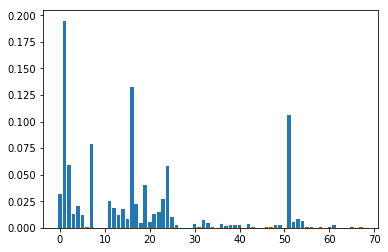

In [105]:
#print(xgb_model_fit.feature_importances_)

plt.bar(range(len(xgb_model_fit.feature_importances_)), xgb_model_fit.feature_importances_)
plt.show();

In [108]:
feature_importance = pd.DataFrame(columns = ['feature', 'importance'])
for index, importance in enumerate(xgb_model_fit.feature_importances_):
    feature_importance.loc[index] = [X.columns[index], importance]
feature_importance.sort_values('importance', inplace = True, ascending = False)
feature_importance.reset_index(drop = True, inplace = True)

In [110]:
feature_importance.head()

,feature,importance
0,user_product_last_purchase_day,0.194986
1,user_history,0.132710
2,days_since_prior_order,0.106645
3,user_product_reorder_ratio,0.078790
4,user_product_order_interval_mean,0.059491


In [111]:
featuredf = feature_importance.iloc[:3,:].sort_values('importance', ascending = True)

In [112]:
import matplotlib

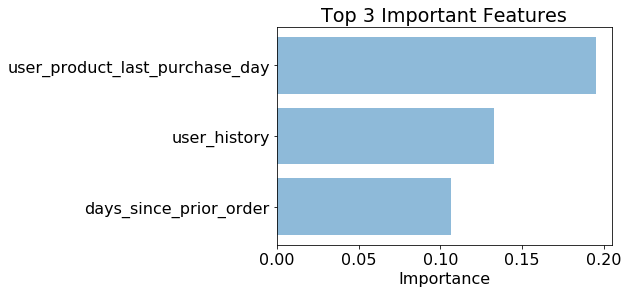

In [113]:
matplotlib.rcParams.update({'font.size': 16})
objects = (featuredf.feature[:3])
y_pos = np.arange(len(objects))
performance = featuredf.importance[:3]
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Importance')
plt.title('Top 3 Important Features')
 
plt.show()

In [152]:
import copy
result_df = copy.deepcopy(train_df )
result_df['XGB_pred_prob'] = xgb_model_fit.predict_proba(X)[:, 1:]

In [143]:
result_df.shape

(8474661, 83)

In [148]:
bins = [0, 0.2, 1]
group_names = [0, 1]
result_df['XGB_pred_y'] = pd.cut(result_df['XGB_pred_prob'], bins, labels=group_names)

In [151]:
new_f1_score(result_df)

0.3764929269287516

### Tuning Parameters

In [195]:
random.seed(808)
random_users = random.sample(set(train_df.user_id), 100)

In [196]:
sample_train_df = train_df[train_df.user_id.isin(random_users)]

In [197]:
sample_train_df.shape

(5972, 82)

In [198]:
def new_f1_score(df):
    TNdf = pd.DataFrame(df[(df.y == 0) & (df.XGB_pred_y == 0)].groupby('user_id')['product_id'].nunique())
    TNdf.rename(columns = {'product_id': 'TN'}, inplace = True)
    TNdf.reset_index(inplace = True)
    
    TPdf = pd.DataFrame(df[(df.y == 1) & (df.XGB_pred_y == 1)].groupby('user_id')['product_id'].nunique())
    TPdf.rename(columns = {'product_id': 'TP'}, inplace = True)
    TPdf.reset_index(inplace = True)
    
    FNdf = pd.DataFrame(df[(df.y == 1) & (df.XGB_pred_y == 0)].groupby('user_id')['product_id'].nunique())
    FNdf.rename(columns = {'product_id': 'FN'}, inplace = True)
    FNdf.reset_index(inplace = True)
    
    FPdf = pd.DataFrame(df[(df.y == 0) & (df.XGB_pred_y == 1)].groupby('user_id')['product_id'].nunique())
    FPdf.rename(columns = {'product_id': 'FP'}, inplace = True)
    FPdf.reset_index(inplace = True)
    
    matrix_df = pd.merge(TNdf, TPdf, on = 'user_id', how = 'outer')
    matrix_df = pd.merge(matrix_df, FNdf, on = 'user_id', how = 'outer')
    matrix_df = pd.merge(matrix_df, FPdf, on = 'user_id', how = 'outer')
    
    matrix_df.fillna(0, inplace = True)
    matrix_df['precision'] = matrix_df.TP / (matrix_df.FP + matrix_df.TP)
    matrix_df['recall'] = matrix_df.TP / (matrix_df.FN + matrix_df.TP)
    matrix_df['f1'] = 2*matrix_df.TP / (2*matrix_df.TP+matrix_df.FP+matrix_df.FN)
    matrix_df.fillna(1, inplace = True)
    return matrix_df.f1.mean()

In [199]:
def man_cross_val(masterdf, learning_rate=0.2, max_depth=6, n_estimators=100, gamma=0, min_child_weight=1, subsample=1, threshold=0.2):
    info_columns = ['user_id', 'product_id', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department', 'order_id', 'eval_set', 'add_to_cart_order', 'y', 'order_hour_group', 'order_dow', 'order_hour_of_day']
    X = masterdf.drop(info_columns, axis = 1)
    y = masterdf.y
    kf = GroupKFold(n_splits=5)
    final_df = pd.DataFrame()
    for i, (train_index, test_index) in enumerate(kf.split(masterdf, groups=masterdf['user_id'].values)):
        xgb_model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, gamma=gamma, min_child_weight=min_child_weight, subsample=subsample)
        xgb_fit = xgb_model.fit(X.iloc[train_index], y.iloc[train_index])
        result = xgb_fit.predict_proba(X.iloc[test_index])
        new_df = masterdf.iloc[test_index][['y', 'user_id', 'product_id']]
        new_df['True'] = result[:, 1:]
        new_df['set'] = i
        final_df = pd.concat([final_df, new_df])
    return final_df

In [200]:
def optimize_threshold(result_df, threshold_list=[0.2]):
    threshold_opt = 0.2
    max_score = 0
    for threshold in threshold_list:
        scores = []
        bins = [0, threshold, 1]
        group_names = [0, 1]
        result_df['XGB_pred_y'] = pd.cut(result_df['True'], bins, labels=group_names).astype(np.float32)
        for i in range(5):
            scores.append(new_f1_score(result_df[result_df.set == i]))
        score = np.mean(scores)
        #print(threshold, score)
        if score > max_score:
            max_score = score
            threshold_opt = threshold
    return threshold_opt, max_score

In [201]:
def tune_para_xgb(masterdf, learning_rate_list=[0.2], max_depth_list=[6], n_estimators_list=[100], gamma_list=[0], min_child_weight_list=[1], subsample_list=[1], threshold_list=[0.2]):
    max_score = 0
    parameters = [0.2, 6, 100, 0, 1, 1, 0.2]
    cols = ['learning_rate', 'max_depth', 'n_estimators', 'gamma', 'min_child_weight_list', 'subsapmle', 'opt_threshold', 'score']
    parameter_df = pd.DataFrame(columns = cols)
    for lr in learning_rate_list:
        for md in max_depth_list:
            for n in n_estimators_list:
                for g in gamma_list:
                    for w in min_child_weight_list:
                        for s in subsample_list:
                            print(lr, md, n, g, w, s)
                            #sys.stdout.flush()
                            temp = optimize_threshold(man_cross_val(masterdf, learning_rate=lr, max_depth=md, n_estimators=n, gamma=g, min_child_weight=w, subsample=s), threshold_list=threshold_list)
                            score = temp[1]
                            threshold_opt = temp[0]
                            parameter_df = parameter_df.append(pd.DataFrame([[lr, md, n, g, w, s, threshold_opt, score]], columns=cols))
                            print(score, threshold_opt)
                            #sys.stdout.flush()
                            if score > max_score:
                                max_score = score
                                parameters = [lr, md, n, g, w, s, threshold_opt]
    return max_score, parameters, parameter_df

In [126]:
learning_rate_list = np.arange(0.05,0.25,0.05)
max_depth_list = [3, 6]
n_estimators_list = np.arange(40,100,20)
gamma_list = [0]
min_child_weight_list = [1, 3]
threshold_list = np.arange(0.1,0.4,0.001)
subsample_list = [0.8, 1]

In [134]:
import copy
masterdf = copy.deepcopy(sample_train_df )

In [40]:
# import sys

# orig_stdout = sys.stdout
# f = open('out.txt', 'w')
# sys.stdout = f

In [ ]:
parameter_optimize_result = tune_para_xgb(masterdf, learning_rate_list=learning_rate_list, max_depth_list=max_depth_list, n_estimators_list=n_estimators_list, gamma_list=gamma_list, min_child_weight_list=min_child_weight_list, subsample_list = subsample_list, threshold_list=threshold_list)

In [49]:
#parameter_optimize_result[2]

,learning_rate,max_depth,n_estimators,gamma,min_child_weight_list,subsapmle,opt_threshold,score
0,0.05,3,40,0,1,0.8,0.213,0.350278
0,0.05,3,40,0,1,1.0,0.211,0.350582
0,0.05,3,40,0,3,0.8,0.213,0.350278
0,0.05,3,40,0,3,1.0,0.211,0.350582
0,0.05,3,60,0,1,0.8,0.180,0.352321
0,0.05,3,60,0,1,1.0,0.189,0.352670
0,0.05,3,60,0,3,0.8,0.180,0.352321
0,0.05,3,60,0,3,1.0,0.189,0.352670
0,0.05,3,80,0,1,0.8,0.162,0.354380
0,0.05,3,80,0,1,1.0,0.166,0.354015


In [ ]:
#pickle.dump(parameter_optimize_result, open('parameter_optimize_result.p', 'wb'))

## Prediction

In [34]:
lr = 0.17
md = 6
n = 60
g = 0
w = 3
s = 1
threshold = 0.197

In [61]:
#xgb_optimized_model = XGBClassifier(learning_rate=lr, max_depth=md, n_estimators=n, gamma=g, min_child_weight=w, subsample=s)

In [62]:
#xgb_optimized_fit = xgb_optimized_model.fit(X,y)

In [63]:
#from sklearn.externals import joblib
#joblib.dump(xgb_optimized_fit, 'Predict_funtion.p') 

['Predict_funtion.p']

In [153]:
test_users = orders[orders.eval_set == 'test'].user_id

In [154]:
test_df = pd.merge(user_product_info[user_product_info.user_id.isin(test_users)], user_info, on = 'user_id', how = 'left')

In [155]:
test_df = pd.merge(test_df, product_info, on = 'product_id', how = 'left')

In [156]:
test_df = pd.merge(test_df, aisle_info, on = 'aisle_id', how = 'left', suffixes=('', '_y'))

In [157]:
test_df = pd.merge(test_df, department_info, on = 'department_id', how = 'left', suffixes=('', '_y'))

In [158]:
test_df = pd.merge(test_df, orders[orders.eval_set == 'test'], on='user_id', how = 'left')

In [159]:
test_df = pd.merge(test_df, order_product_train, on =['order_id', 'product_id'], how = 'left')

In [160]:
hour_bins = [-1,2,6,10,14,18,22,25]
hour_gourp_names = ['22-2', '3-6', '7-10', '11-14', '15-18', '19-22', '22-2']
test_df['order_hour_group'] = pd.cut(test_df.order_hour_of_day, bins = hour_bins, labels=hour_gourp_names)

In [161]:
test_df = pd.merge(test_df, ordertime_info, on = ['order_dow', 'order_hour_group'], how = 'left')

In [162]:
test_df = pd.merge(test_df, user_ordertime_info, on = ['user_id', 'order_dow', 'order_hour_group'], how = 'left')

In [163]:
test_df = pd.merge(test_df, product_ordertime_info, on = ['product_id', 'order_dow', 'order_hour_group'], how = 'left')

In [164]:
test_df['user_ordertime_order_num'].fillna(0, inplace = True)
test_df['product_ordertime_order_num'].fillna(0, inplace = True)

In [165]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['order_hour_group'])], axis = 1)

In [166]:
test_df = pd.concat([test_df, pd.get_dummies(test_df['order_dow'], prefix='order_dow')], axis = 1)

In [176]:
info_columns_test = ['user_id', 'product_id', 'product_name', 'aisle_id', 'department_id', 'aisle', 'department', 'order_id', 'eval_set', 'add_to_cart_order', 'order_hour_group', 'order_dow', 'order_hour_of_day', 'reordered']

In [177]:
X_test = test_df.drop(info_columns_test, axis = 1)

In [169]:
X_test.shape

(4833292, 69)

In [179]:
test_df['True'] = xgb_model_fit.predict_proba(X_test)[:,1:]

In [180]:
bins = [0, 0.2, 1]
group_names = [0, 1]

In [181]:
test_df['XGB_pred_y'] = pd.cut(test_df['True'], bins, labels=group_names)

In [182]:
test_df.order_id.nunique()

75000

In [183]:
test_df.head()

,user_id,product_id,user_product_order_num,user_product_last_purchase_day,user_product_order_interval_mean,user_product_order_interval_std,user_product_rank,user_product_add_order_mean,user_product_add_order_std,user_product_reorder_ratio,...,7-10,order_dow_0,order_dow_1,order_dow_2,order_dow_3,order_dow_4,order_dow_5,order_dow_6,True,XGB_pred_y
0,3,248,1,9,42.677544,25.335363,26.5,3.000000,4.219923,0.083333,...,0,0,0,0,0,0,1,0,0.020925,0
1,3,1005,1,107,42.677544,25.335363,26.5,5.000000,4.219923,0.083333,...,0,0,0,0,0,0,1,0,0.047144,0
2,3,1819,3,76,13.000000,8.485281,10.0,2.666667,2.081666,0.250000,...,0,0,0,0,0,0,1,0,0.110314,0
3,3,7503,1,30,42.677544,25.335363,26.5,6.000000,4.219923,0.083333,...,0,0,0,0,0,0,1,0,0.029502,0
4,3,8021,1,9,42.677544,25.335363,26.5,5.000000,4.219923,0.083333,...,0,0,0,0,0,0,1,0,0.035120,0


In [184]:
result = test_df[test_df.XGB_pred_y == 1][['order_id', 'product_id']].reset_index(drop = True)

In [185]:
submission = pd.DataFrame(result.groupby('order_id').aggregate(lambda x: tuple(x)), columns = ['product_id']).reset_index()

In [186]:
submission['products'] = submission.product_id.apply(lambda x: ' '.join([str(a) for a in x]))

In [187]:
submission.drop('product_id', axis = 1, inplace=True)

In [188]:
submission.head()

,order_id,products
0,17,13107 21463 21709 38777 47766
1,34,2596 13176 16083 18618 21137 21463 39180 39475...
2,137,2326 5134 23794 24852 25890 29594 38689 41787
3,182,5479 9337 11520 13629 15252 27104 33000 35951 ...
4,257,21137 24852 27104 27966 29837 30233 37646 3947...


In [189]:
new_submission = pd.merge(orders[orders.eval_set == 'test'], submission, on = 'order_id', how = 'left')

In [190]:
new_submission = new_submission[['order_id', 'products']]

In [191]:
new_submission = new_submission.sort_values('order_id').reset_index(drop =True)

In [192]:
new_submission.to_csv('submission.csv', index=False)

In [193]:
new_submission.shape

(75000, 2)